# MobileNet V2 Tensorflow로 구현해보기 실습
이번 실습에서는 Tensorflow Functional API를 이용하여 이미지를 구분하는 Neural Network를 MobileNet V2 구조로 구현해 보는 실습을 진행할 것이다. <br>
그 중에서도 가장 핵심이라고 할 수 있는 Linear bottleneck과 Inverted residuals를 중점적으로 다룰 것이다.

In [1]:
import os
import socket
import pickle
import time
import numpy as np
import struct
from tqdm import tqdm
from sys import getsizeof
from datetime import datetime
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Add, ReLU, Input, Dense, Dropout, Activation, Flatten \
    , Conv2D, MaxPooling2D, InputLayer, Reshape, DepthwiseConv2D, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.engine.topology import Input
from tensorflow.keras.optimizers import RMSprop


from tensorflow.keras.callbacks import CSVLogger

In [2]:
from tensorflow.python.keras import backend
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.keras.applications import imagenet_utils

In [3]:
from sklearn import model_selection
import math

## Setting GPU
GPU가 없으면 아래 Step은 건너뛰어도 좋다.

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU')
gpus
idx = 0
tf.config.experimental.set_visible_devices(gpus[idx], 'GPU')
tf.config.experimental.set_memory_growth(gpus[idx], True)

## Setting Hyperparameters
훈련 데이터셋은 cifar10을 사용할 것이고, 주요 Hyperparameter들은 MobilenetV2의 ImageNet training에 사용한 값들을 사용할 것이다.<br>
Classification을 위한 Hyperparameter들을 아래와 같이 설정한다.


In [5]:
num_classes = 10
batch_size=96
num_epochs   = 10

## Dataset

**앞의 Tutorial과 비슷한 방식으로 전처리하도록 수정 필요 TFDS를 활용...**

!wget http://cs231n.stanford.edu/tiny-imagenet-200.zip
!unzip tiny-imagenet-200.zip

In [6]:
(train_images, train_labels), (test_images, test_labels) = cifar10.load_data()
#(ds_train, ds_test), ds_info = tfds.load('cifar10', split=['train','test'], shuffle_files=True, as_supervised=True, with_info=True)

train_images, val_images, train_labels, val_labels = model_selection.train_test_split(train_images, train_labels, test_size=0.5)
train_images, val_images, test_images = train_images / 255.0, val_images / 255.0, test_images / 255.

train_labels = keras.utils.to_categorical(train_labels, num_classes)
val_labels = keras.utils.to_categorical(val_labels, num_classes)
test_labels = keras.utils.to_categorical(test_labels, num_classes)


## Helper functions

In [7]:
def _make_divisible(v, divisor, min_value=None):
    if min_value is None:
        min_value = divisor
    new_v = max(min_value, int(v + divisor / 2) // divisor * divisor) # 더 가까운 divisor의 배수로 올림 4,5,6,7,8,9,10,11 -> 8, 12~19 -> 16 ...
    # Make sure that round down does not go down by more than 10%.
    if new_v < 0.9 * v:
        new_v += divisor
    return new_v

In [8]:
#This is referenced from imagenet_utils source code
#change in this part does not have influence on main code.
def correct_pad(inputs, kernel_size):
    """Returns a tuple for zero-padding for 2D convolution with downsampling.
    Arguments:
    inputs: Input tensor.
    kernel_size: An integer or tuple/list of 2 integers.
    Returns:
    A tuple.
    """
    img_dim = 2 if backend.image_data_format() == 'channels_first' else 1
    input_size = backend.int_shape(inputs)[img_dim:(img_dim + 2)]
    if isinstance(kernel_size, int):
        kernel_size = (kernel_size, kernel_size)
    if input_size[0] is None:
        adjust = (1, 1)
    else:
        adjust = (1 - input_size[0] % 2, 1 - input_size[1] % 2)
    correct = (kernel_size[0] // 2, kernel_size[1] // 2)
    return ((correct[0] - adjust[0], correct[0]),
          (correct[1] - adjust[1], correct[1]))

### Inverted residual / Linear bottleneck layer
3파트로 나누어 생각해 볼 수 있다.
1. Expansion: 1x1 convolution으로 채널의 수를 expansion배만큼 증가시킨다. Activation은 RELU6이다.<br>
2. Depthwise convolution: 3x3 convolution을 수행하며 Stride가 적용되어 Output의 size가Input과 달라질 수 있다. Activation은 RELU6이다.
3. Linear bottleneck: 1x1 convolution으로 채널의 수를 filters로 줄여준다. <br>

각 Layer에는 Batch normalization이 따라오고, 최종 위 3 단계를 거친 Layer와 Input을 합쳐서(Residual) return해주어야 한다.

Hyper parameter의 경우는 ImageNet classification에 사용된 값을 준용하도록 하자.<br>
BN에 사용되는 epsilon=0.001, momentum=0.999를 사용하자. <br>
또한 Standard weight decay=0.00004를 사용하도록 하자.(L2 regularizer) <br>

*TF mobilenetV2 소스코드상에는 없는데 standard weight decay가 L2 regularizer가 맞나? <br>
make_divisible로 채널 크기가 8의 배수가 되도록 하는 이유는 무엇인가?<br>
Depthwise Conv 2D에서 Zero padding을 추가적으로 해줘야 하는 이유가 있는지? padding=same으로 하면 안되는가?*

In [9]:
def _inverted_res_block(inputs, expansion, stride, alpha, filters, block_id):
    #Get the channel axis and the input channel size
    channel_axis = 1 if backend.image_data_format() == 'channels_first' else -1
    in_channels = backend.int_shape(inputs)[channel_axis]
    
    pointwise_conv_filters = int(alpha * filters)
    pointwise_filters = _make_divisible(pointwise_conv_filters, 8) # Make sure the output filter size is the multiple of 8
    
    #Set the prefix
    prefix = 'block_{}_'.format(block_id)
    
    x = inputs
    
    #Expansion block    
    if block_id: # No expansion for block 0
        x = layers.Conv2D(filters = expansion * in_channels, kernel_size = 1, strides = 1, padding='same',
                          use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                          name=prefix + 'expand')(x)
        x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001, 
                                      name=prefix + 'expand_BN')(x)
        x = layers.ReLU(6, name=prefix + 'expand_relu')(x)
    else: 
        prefix = 'expanded_conv_'
    
    
    #Depthwise convolution
    #if stride == 2:
        #Adjust zero paddings for strides, when input hieght and width are odd add (1,1,1,1) padding / when even, add (0,1,0,1)
        #x = layers.ZeroPadding2D(padding=correct_pad(x, 3),
        #                         name=prefix + 'pad')(x)
    
    x = layers.DepthwiseConv2D(kernel_size = 3, strides = stride, 
                               #padding='same' if stride == 1 else 'valid',
                               padding='same',
                               use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                               name=prefix + 'depthwise')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'depthwise_BN')(x)
    x = layers.ReLU(6, name=prefix + 'relu')(x)
    
    #Pointwise convolution(Bottleneck)
    x = layers.Conv2D(filters = pointwise_filters, kernel_size = 1, strides = 1, padding='same',
                      use_bias=False, activation=None, kernel_regularizer=regularizers.l2(0.00004),
                      name=prefix + 'project')(x)
    x = layers.BatchNormalization(axis=channel_axis, momentum=0.999, epsilon=0.001,
                                 name=prefix + 'project_BN')(x)
    
    #Inverted residual only when valid(Input size = output_size)
    if in_channels == pointwise_filters and stride == 1:
        return layers.add([inputs, x])
    return x

In [10]:
def MobileNetV2(input_shape,
                classes,
                alpha=1.0):
    
    
    inputs = layers.Input(shape=input_shape)
    
    first_block_filters = _make_divisible(32 * alpha, 8)
    # first conv layer
    x = layers.Conv2D(first_block_filters, kernel_size=3, strides=(2, 2), padding='same',  use_bias=False, 
                      bias_initializer='zeros',  kernel_regularizer=regularizers.l2(0.00004),
                      name='Conv1')(inputs)
    
    x = layers.BatchNormalization(
      axis=-1, epsilon=1e-3, momentum=0.999, name='bn_Conv1')(x)
    
    x = layers.ReLU(6., name='Conv1_relu')(x)
    
    
    # inverted residual blocks
    x = _inverted_res_block(
      x, filters=16, alpha=alpha, stride=1, expansion=1, block_id=0)

    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=2, expansion=6, block_id=1)
    x = _inverted_res_block(
      x, filters=24, alpha=alpha, stride=1, expansion=6, block_id=2)

    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=2, expansion=6, block_id=3)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=4)
    x = _inverted_res_block(
      x, filters=32, alpha=alpha, stride=1, expansion=6, block_id=5)

    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=2, expansion=6, block_id=6)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=7)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=8)
    x = _inverted_res_block(
      x, filters=64, alpha=alpha, stride=1, expansion=6, block_id=9)

    x = _inverted_res_block(
      x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=10)
    x = _inverted_res_block(
      x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=11)
    x = _inverted_res_block(
      x, filters=96, alpha=alpha, stride=1, expansion=6, block_id=12)

    x = _inverted_res_block(
      x, filters=160, alpha=alpha, stride=2, expansion=6, block_id=13)
    x = _inverted_res_block(
      x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=14)
    x = _inverted_res_block(
      x, filters=160, alpha=alpha, stride=1, expansion=6, block_id=15)

    x = _inverted_res_block(
      x, filters=320, alpha=alpha, stride=1, expansion=6, block_id=16)
    
    
    if alpha > 1.0:
        last_block_filters = _make_divisible(1280 * alpha, 8)
    else:
        last_block_filters = 1280    
    
    # conv layer
    x = layers.Conv2D(last_block_filters, 
                      kernel_size=1, 
                      use_bias=False,                                              
                      kernel_regularizer=regularizers.l2(0.00004),                      
                      name='Conv_1')(x)
    
    x = layers.BatchNormalization(axis=-1, 
                                  epsilon=1e-3, 
                                  momentum=0.999, 
                                  name='Conv_1_bn')(x)
    
    x = layers.ReLU(6., name='out_relu')(x)
    
    # average pooling
    x = layers.GlobalAveragePooling2D()(x)
    
    # FC layer
    outputs = layers.Dense(classes, 
                           activation='softmax',                                                        
                           kernel_regularizer=regularizers.l2(0.00004),                           
                           name='predictions')(x)

    
    return Model(inputs=inputs, outputs=outputs)

In [11]:
IMG_SIZE = 300
n_classes = 10
max_output_size = 200
pos_iou_threshold = 0.5
neg_iou_threshold = 0.5
score_threshold = 0.01
layer_width=[38,19,10,5,3,1]
num_boxes = [4,6,6,6,4,4]
aspect_ratio = [1,1,2,1/2,3,1/3]
s_max = 0.9
s_min = 0.2
batch_size = 32
log_dir = './'
model_name = 'mobilenetSSD'
model_csv_path  = os.path.join(log_dir, (model_name + '.csv'))

In [12]:
#Load data
(x_train, y_train), (x_test, y_test) = keras.datasets.cifar10.load_data()

In [13]:
import cv2

train_size = x_train.shape[0]
x_train_resize = np.zeros((train_size, 64, 64, 3))
test_size = x_test.shape[0]
x_test_resize = np.zeros((test_size, 64, 64, 3))

for i, image in enumerate(x_train):
    x_train_resize[i] = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

for i, image in enumerate(x_test):
    x_test_resize[i] = cv2.resize(image, dsize=(64, 64), interpolation=cv2.INTER_CUBIC)

In [38]:
def convert(x, y, small_x, canvas_size):
    """
    Convert classification data to object detection data
    Randomly locate image in the middle of black canvas    
    Input
        x: Image, shape: (batch_size, image size, image size, #channels)
        y: label, shape: (batch_size, )
    output
        out_x: Image located in the random location of black canvas, shape: (batch_size, canvas size, canvas size, 3)
        out_y: label and location of corners(xmin,ymin,xmax,ymax), shape: (batch_size, #objects per image, 1+4) #Objects per image = 1
                                                                
    """
    #get batch size and image size
    batch_size = 32
    image_size = x.shape[-2]
    small_image_size = small_x.shape[-2]
    channels = x.shape[-1]
    
    #prepare black canvas
    canvas = np.zeros((batch_size, canvas_size, canvas_size, channels), dtype=np.int)
    out_y = np.zeros((batch_size,2, 5))
    
    xmin = np.random.randint(canvas_size - image_size, size = (batch_size,))
    ymin = np.random.randint(canvas_size - image_size, size = (batch_size,))
    xmax = xmin + image_size
    ymax = ymin + image_size
    
    small_xmin = np.zeros(batch_size, dtype=np.int)
    small_ymin = np.zeros(batch_size, dtype=np.int)
    small_xmax = np.zeros(batch_size, dtype=np.int)
    small_ymax = np.zeros(batch_size, dtype=np.int)
        
    for i in range(batch_size):
        canvas[i, xmin[i]:xmax[i], ymin[i]:ymax[i], :] = x[i]
        if canvas_size - xmax[i]> xmin[i]:
            small_xmin[i] = np.random.randint(xmax[i], canvas_size - small_image_size)
        else: 
            small_xmin[i] = np.random.randint(xmin[i])
            
        if canvas_size - ymax[i] > ymin[i]:
            small_ymin[i] = np.random.randint(ymax[i], canvas_size - small_image_size)
        else: 
            small_ymin[i] = np.random.randint(ymin[i])
            
        small_xmax[i] = small_xmin[i] + small_image_size
        small_ymax[i] = small_ymin[i] + small_image_size
        
        canvas[i, small_xmin[i]:small_xmax[i], small_ymin[i]:small_ymax[i], :] = small_x[i]
        
        
    out_y[:,0,0] = y[:,0]
    out_y[:,1,0] = y[:,0]
    out_y[:, 0, -4:] = np.column_stack([xmin, ymin, xmax, ymax])
    out_y[:, 1, -4:] = np.column_stack([small_xmin, small_ymin, small_xmax, small_ymax])    
    
    return canvas, out_y

In [39]:
import tensorflow_datasets as tfds

In [40]:
(dataset_train, dataset_test), ds_info = tfds.load(
    'cifar10',
    split=['train', 'test'],
    shuffle_files=True,
    as_supervised=True,
    with_info=True,
)

In [41]:
def convert_image_ds(image, label):
    """
    Convert classification data to object detection data
    Randomly locate image in the middle of black canvas    
    Input
        x: Image, shape: (batch_size, image size, image size, #channels)
        y: label, shape: (batch_size, )
    output
        out_x: Image located in the random location of black canvas, shape: (batch_size, canvas size, canvas size, 3)
        out_y: label and location of corners(xmin,ymin,xmax,ymax), shape: (batch_size, #objects per image, 1+4) #Objects per image = 1
                                                                
    """
    #get batch size and image size
    image_size = image.shape[-2]
    channels = image.shape[-1]
    
    #prepare black canvas
    canvas = np.zeros((300, 300, channels), dtype=np.int)
    out_y = np.zeros((1,5))
    
    xmin = np.random.randint(300 - image_size)
    ymin = np.random.randint(300 - image_size)
    xmax = xmin + image_size
    ymax = ymin + image_size
           
    canvas[xmin:xmax, ymin:ymax, :] = image
        
        
    out_y[0,0] = label
    out_y[0,-4:] = [xmin, ymin, xmax, ymax]   
    
    return canvas, out_y

In [42]:
def convert_ds_wrap(image, label):
    canvas_shape = [300,300,3]
    label_shape = [1,5]
    [image_mod, label_mod] = tf.py_function(convert_image_ds, [image, label], [tf.int32, tf.int32])
    
    image_mod.set_shape(canvas_shape)
    label_mod.set_shape(label_shape)
    
    return image_mod, label_mod    

In [43]:
ds_train = dataset_train.map(
    convert_ds_wrap, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
    deterministic=False
)

In [44]:
def show(image, label):
    plt.figure()
    plt.imshow(image)
    plt.title(label.numpy())
    plt.axis('off')

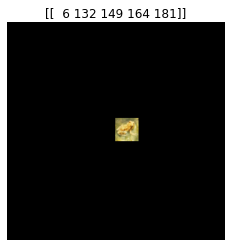

In [45]:
for image, label in ds_train.take(1):
    show(image, label)

In [46]:
x_train_od, y_train_od = convert(x_train_resize, y_train, x_train, IMG_SIZE)
x_test_od, y_test_od = convert(x_test_resize, y_test, x_test, IMG_SIZE)

ValueError: could not broadcast input array from shape (50000) into shape (32)

In [28]:
def calc_iou(gt, anchor_boxes):        
        """
        Calculate IOU of ground truth and anchor boxes
        
        Input:
            gt: ground truth image, shape: (#object per image, 4)
            anchor_boxes: anchor boxes, shape: (sum of grid size of all classifier * num_boxes, 4)
        Output:
            Matrix of iou. Row indicates each ground truth box and column indicates each anchor box.
            shape: (#object per image, sum of grid size of all classifier)
        
        
        """
        i_xmin = 0
        i_ymin = 1
        i_xmax = 2
        i_ymax = 3        
        
        m = gt.shape[0] # Object per image
        n = anchor_boxes.shape[0] # Number of all boxes
        
        #Calculate min_xy
        min_xy = np.maximum(np.tile(np.expand_dims(gt[:,0:2], axis = 1), reps = (1,n,1)),
                            np.tile(np.expand_dims(anchor_boxes[:, 0:2], axis = 0), reps = (m,1,1)))
        
        #Calculate max_xy
        max_xy = np.minimum(np.tile(np.expand_dims(gt[:,2:4], axis = 1), reps = (1,n,1)),
                            np.tile(np.expand_dims(anchor_boxes[:, 2:4], axis = 0), reps = (m,1,1)))
        
        #calculate intersection
        intersection = np.maximum((max_xy - min_xy)[:,:,0],0) * np.maximum((max_xy - min_xy)[:,:,1],0)
        
        #calculate union
        edge_gt = np.tile(np.expand_dims(gt[:,2:4] - gt[:,0:2], axis = 1), reps = (1,n,1))         
        area_gt = edge_gt[:,:,0] * edge_gt[:,:,1]
        
        edge_anchor_boxes = np.tile(np.expand_dims(anchor_boxes[:,2:4] - anchor_boxes[:,0:2], axis = 0), reps = (m,1,1))         
        area_anchor_boxes = edge_anchor_boxes[:,:,0] * edge_anchor_boxes[:,:,1]

        union = area_gt + area_anchor_boxes - intersection
        
        return intersection / union

In [29]:
def match_bipartite_greedy(weight_matrix):
    """
    Calculate the highest matching anchor box per each ground truth
    Input: iou between each ground truth and anchor boxes, shape: (#gt, #anchor boxes)
    Output: List of matched anchor per each ground truth
    """
    m = weight_matrix.shape[0]
    n = weight_matrix.shape[1]
    
    matches = np.zeros(m, dtype = np.int)
    weight_cp = np.copy(weight_matrix)
    
    #Find the largest iou per each ground truth box in descending order
    for _ in range(m):
        largest_indices = np.argmax(weight_cp, axis = 1)
        iou_largest = weight_cp[list(range(m)), largest_indices]
        match_gt = np.argmax(iou_largest, axis = 0)
        match_anchor = largest_indices[match_gt]
        matches[match_gt] = match_anchor
        
        #Set the selected ground truth to 0, matched anchor box to 0 as well.
        weight_cp[match_gt, :] = 0
        weight_cp[:, match_anchor] = 0
        
    return matches    

In [30]:
def match_multi(weight_matrix, threshold):
    """
    Multiple object match
    From remaining anchor boxexk, find the most similar ground truth 
    whose iou is greater than pos_threshold
    """
    m = weight_matrix.shape[0]
    n = weight_matrix.shape[1]

    #Find the largest iou per each anchor box
    largest_indices = np.argmax(weight_matrix, axis = 0)
    iou_largest = weight_matrix[largest_indices, list(range(n))]
    
    #Filter iou is greater than the threshold
    matches_anchor = np.nonzero(iou_largest >= threshold)[0].astype(np.int)
    matches_gt = iou_largest[matches_anchor].astype(np.int)
    
    return matches_anchor, matches_gt

In [31]:
def convert_coord(boxes, type='centroid2corner'):
    """
        Input: Input labels 
        type: how to convert
            centroid2corner: (cx, cy, w, h) -> (xmin, ymin, xmax, ymax)
            corner2centroid: (xmin, ymin, xmax, ymax) -> (cx, cy, w, h)    
    """
    
    if type=='centroid2corner':
        cx = boxes[..., 0]
        cy = boxes[..., 1]
        w = boxes[..., 2]
        h = boxes[..., 3]
        
        converted_boxes = np.copy(boxes)
        converted_boxes[..., 0] = cx - w / 2 #xmin
        converted_boxes[..., 1] = cy - h / 2 #ymin
        converted_boxes[..., 2] = cx + w / 2 #xmax
        converted_boxes[..., 3] = cy + h / 2 #ymax
    elif type=='corner2centroid':
        xmin = boxes[..., 0]
        ymin = boxes[..., 1]
        xmax = boxes[..., 2]
        ymax = boxes[..., 3]
        
        converted_boxes = np.copy(boxes)
        
        converted_boxes[..., 0] = (xmin + xmax) / 2 #cx
        converted_boxes[..., 1] = (ymin + ymax) / 2 #cy
        converted_boxes[..., 2] = xmax - xmin #w
        converted_boxes[..., 3] = ymax - ymin #h
        
    return converted_boxes

In [32]:
class SSDInputEncoder():
    def __init__(self, 
                 img_height, 
                 img_width, 
                 layer_width, 
                 n_classes, 
                 num_boxes, 
                 s_max, 
                 s_min, 
                 aspect_ratio, 
                 pos_iou_threshold,
                 neg_iou_threshold,
                background_id):
        #Consider Background class
        self.img_height = img_height
        self.img_width = img_width
        self.n_classes = n_classes + 1  #Add background class
        self.num_boxes = num_boxes  #List of number of boxes in each classifier layer
        self.s_max = s_max # Largest scale of default box
        self.s_min = s_min # Smallest scale of default box
        self.aspect_ratio = aspect_ratio # List of aspect ratios
        self.layer_width = layer_width
        self.pos_iou_threshold = pos_iou_threshold
        self.neg_iou_threshold = neg_iou_threshold
        self.background_id = background_id
        
        
    def __call__(self, gt_label):
        """
        Input: ground truth label,shape: (batch_size, #object per image, 1 + 4)
        Output: y_encoded, shape: (batch_size, sum of grid size of all classifier * num_boxes, n_classes + 4 + 4)
        1. Create y_encoded template: (B, num_boxes, class + 4 + 4) 4 for gt coordinates and 4 for anchor boxes
        2. For each ground truth, calculate iou of gt and anchor boxes
        3. Find the highest matching anchor box per each gt and fill in y_encoded template
        4. Multi object matching
        5. Apply negative iou threshold
        6. Transform into Delta format
        """
        batch_size = gt_label.shape[0]        
        sum_l2 = 0
        
        i_xmin = 0
        i_ymin = 1
        i_xmax = 2
        i_ymax = 3
        
        # Make class vector to one hot format
        class_vector = np.eye(self.n_classes)
        
        
        for iw in range(len(layer_width)):
            s = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw - 1)
            l = layer_width[iw]            
            num_box = self.num_boxes[iw]            
            box_tensor = np.zeros((l * l * num_box, 4))
            for i in range(layer_width[iw]):                    
                for j in range(layer_width[iw]):
                    for box_idx in range(num_box):
                        box_tensor[(i * l + j) * num_box + box_idx, 0]  = (0.5 + i) / l * self.img_width
                        box_tensor[(i * l + j) * num_box + box_idx, 1]  = (0.5 + j) / l * self.img_height
                        
                        if box_idx == 0:
                            s_next = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw)
                            box_tensor[(i * l + j) * num_box + box_idx, 2]  = math.sqrt(aspect_ratio[box_idx]) / l * math.sqrt(s * s_next) * self.img_width
                            box_tensor[(i * l + j) * num_box + box_idx, 3]  = 1 / math.sqrt(aspect_ratio[box_idx]) / l * math.sqrt(s * s_next) * self.img_height                            
                        else:                            
                            box_tensor[(i * l + j) * num_box + box_idx, 2]  = math.sqrt(aspect_ratio[box_idx]) / l * s * self.img_width
                            box_tensor[(i * l + j) * num_box + box_idx, 3]  = 1 / math.sqrt(aspect_ratio[box_idx]) / l * s * self.img_height
                        
            box_tensor = convert_coord(box_tensor, type='centroid2corner')
            
            if iw == 0:
                boxes_tensor = box_tensor                
            else:                    
                boxes_tensor = np.concatenate((boxes_tensor, box_tensor), axis = 0)
            
            class_tensor = np.zeros((l * l * num_box , self.n_classes))
            
            if iw == 0:
                classes_tensor = class_tensor                
            else:                    
                classes_tensor = np.concatenate((classes_tensor, class_tensor), axis = 0)
                
        box_class_tensor= np.concatenate((classes_tensor, boxes_tensor, boxes_tensor), axis = 1)
        y_encoded = np.tile(box_class_tensor, (batch_size, 1, 1))
        
        y_encoded[:, :, self.background_id] = 1 # All boxes are background boxes by default.
        
    
        for i in range(batch_size):
            gt_one_label = gt_label[i]
            m = gt_one_label.shape[0]
            if gt_one_label.shape[0] == 0: continue # If there is no object, skip
            
            #FInd the iou of ground truth and all anchor boxes
            similarities = calc_iou(gt_one_label[:,-4:], y_encoded[i, :, -4:])            
            
            #Find the highest matching anchor box per each ground truth boxes
            matches = match_bipartite_greedy(similarities)
            
            #Convert ground truth class label to one hot encoding            
            gt_class = np.array(gt_one_label[:,0], dtype=np.int)
                        
            #Fill in y_encoded
            y_encoded[i, matches, :self.n_classes] = class_vector[gt_class]
            y_encoded[i, matches, -8:-4] = gt_one_label[:,1:]
            
            #Set the matched anchor boxes to 0 to indicate they are matched before multi object matching
            similarities[:,matches] = 0
            
            
            #Multi object matching
            #Similar process to bipartite matching
            matches_anchor, matches_gt = match_multi(similarities, threshold=self.pos_iou_threshold)            
            
            if len(matches_gt) > 0:            

                y_encoded[i, matches_anchor, :self.n_classes] = class_vector[gt_class[matches_gt]]           
                y_encoded[i, matches_anchor, -8:-4] = gt_one_label[matches_gt,1:]

                #Set the matched anchor boxes to 0 to indicate they are matched before applying negative iou threshold
                similarities[:,matches_anchor] = 0
            
            #All background boxes whose iou are greater than neg_iou_threshold 
            # are set to neutral(neither background nor class)
            max_bg_similarities = np.amax(similarities, axis = 0)
            neutral_boxes = np.nonzero(max_bg_similarities >= self.neg_iou_threshold)[0]
            y_encoded[i, neutral_boxes, self.background_id] = 0
        
        y_encoded[:,:,[-8, -7]] -= y_encoded[:,:,[-4, -3]] # (cx(gt) - cx(d_box)) # (cy(gt) - cy(d_box))
        y_encoded[:,:,[-8, -7]] /= y_encoded[:,:,[-2, -1]] # (cx(gt) - cx(d_box)) / w(d_box) # (cy(gt) - cy(d_box)) / h(d_box)
        y_encoded[:,:,[-6, -5]] = np.log(y_encoded[:,:,[-6, -5]] / y_encoded[:,:,[-2, -1]]) #log(w(gt) / w(d_box)) #log(h(gt) / h(d_box))
                  
        return y_encoded 

In [33]:
ssd_input = SSDInputEncoder(IMG_SIZE, 
                 IMG_SIZE, 
                 layer_width=layer_width, 
                 n_classes=n_classes, 
                 num_boxes=num_boxes, 
                 s_max=s_max, 
                 s_min=s_min, 
                 aspect_ratio=aspect_ratio, 
                 pos_iou_threshold=pos_iou_threshold,
                 neg_iou_threshold=neg_iou_threshold,
                 background_id=10)
y_train_encoded = ssd_input(y_train_od)
y_test_encoded = ssd_input(y_test_od)

NameError: name 'y_train_od' is not defined

In [34]:
class SSDInputEncoder_ds():
    def __init__(self, 
                 img_height, 
                 img_width, 
                 layer_width, 
                 n_classes, 
                 num_boxes, 
                 s_max, 
                 s_min, 
                 aspect_ratio, 
                 pos_iou_threshold,
                 neg_iou_threshold,
                background_id):
        #Consider Background class
        self.img_height = img_height
        self.img_width = img_width
        self.n_classes = n_classes + 1  #Add background class
        self.num_boxes = num_boxes  #List of number of boxes in each classifier layer
        self.s_max = s_max # Largest scale of default box
        self.s_min = s_min # Smallest scale of default box
        self.aspect_ratio = aspect_ratio # List of aspect ratios
        self.layer_width = layer_width
        self.pos_iou_threshold = pos_iou_threshold
        self.neg_iou_threshold = neg_iou_threshold
        self.background_id = background_id
        
        
    def __call__(self, gt_label):
        """
        Input: ground truth label,shape: (batch_size, #object per image, 1 + 4)
        Output: y_encoded, shape: (batch_size, sum of grid size of all classifier * num_boxes, n_classes + 4 + 4)
        1. Create y_encoded template: (B, num_boxes, class + 4 + 4) 4 for gt coordinates and 4 for anchor boxes
        2. For each ground truth, calculate iou of gt and anchor boxes
        3. Find the highest matching anchor box per each gt and fill in y_encoded template
        4. Multi object matching
        5. Apply negative iou threshold
        6. Transform into Delta format
        """
                
        i_xmin = 0
        i_ymin = 1
        i_xmax = 2
        i_ymax = 3
        
        # Make class vector to one hot format
        class_vector = np.eye(self.n_classes)        
        
        for iw in range(len(layer_width)):
            s = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw - 1)
            l = layer_width[iw]            
            num_box = self.num_boxes[iw]            
            box_tensor = np.zeros((l * l * num_box, 4))
            for i in range(layer_width[iw]):                    
                for j in range(layer_width[iw]):
                    for box_idx in range(num_box):
                        box_tensor[(i * l + j) * num_box + box_idx, 0]  = (0.5 + i) / l * self.img_width
                        box_tensor[(i * l + j) * num_box + box_idx, 1]  = (0.5 + j) / l * self.img_height
                        
                        if box_idx == 0:
                            s_next = s_min + (s_max - s_min) / (len(layer_width) - 1) * (len(layer_width) - iw)
                            box_tensor[(i * l + j) * num_box + box_idx, 2]  = math.sqrt(aspect_ratio[box_idx]) / l * math.sqrt(s * s_next) * self.img_width
                            box_tensor[(i * l + j) * num_box + box_idx, 3]  = 1 / math.sqrt(aspect_ratio[box_idx]) / l * math.sqrt(s * s_next) * self.img_height                            
                        else:                            
                            box_tensor[(i * l + j) * num_box + box_idx, 2]  = math.sqrt(aspect_ratio[box_idx]) / l * s * self.img_width
                            box_tensor[(i * l + j) * num_box + box_idx, 3]  = 1 / math.sqrt(aspect_ratio[box_idx]) / l * s * self.img_height
                        
            box_tensor = convert_coord(box_tensor, type='centroid2corner')
            
            if iw == 0:
                boxes_tensor = box_tensor                
            else:                    
                boxes_tensor = np.concatenate((boxes_tensor, box_tensor), axis = 0)
            
            class_tensor = np.zeros((l * l * num_box , self.n_classes))
            
            if iw == 0:
                classes_tensor = class_tensor                
            else:                    
                classes_tensor = np.concatenate((classes_tensor, class_tensor), axis = 0)
                
        box_class_tensor= np.concatenate((classes_tensor, boxes_tensor, boxes_tensor), axis = 1)
        y_encoded = box_class_tensor
        
        y_encoded[:, self.background_id] = 1 # All boxes are background boxes by default.
        
    

        gt_one_label = gt_label
        m = gt_one_label.shape[0]
        if gt_one_label.shape[0] == 0: 
            return y_encoded# If there is no object, skip

        #FInd the iou of ground truth and all anchor boxes
        similarities = calc_iou(gt_one_label[:,-4:], y_encoded[:, -4:])            

        #Find the highest matching anchor box per each ground truth boxes
        matches = match_bipartite_greedy(similarities)

        #Convert ground truth class label to one hot encoding            
        gt_class = np.array(gt_one_label[:,0], dtype=np.int)

        #Fill in y_encoded
        y_encoded[matches, :self.n_classes] = class_vector[gt_class]
        y_encoded[matches, -8:-4] = gt_one_label[:,1:]

        #Set the matched anchor boxes to 0 to indicate they are matched before multi object matching
        similarities[:,matches] = 0


        #Multi object matching
        #Similar process to bipartite matching
        matches_anchor, matches_gt = match_multi(similarities, threshold=self.pos_iou_threshold)            
        
        for i in range(len(matches_anchor)):

            y_encoded[matches_anchor[i], :self.n_classes] = class_vector[gt_class[matches_gt[i]]]           
            y_encoded[matches_anchor[i], -8:-4] = gt_one_label[matches_gt[i],1:]

            #Set the matched anchor boxes to 0 to indicate they are matched before applying negative iou threshold
            similarities[:,matches_anchor] = 0

        #All background boxes whose iou are greater than neg_iou_threshold 
        # are set to neutral(neither background nor class)
        max_bg_similarities = np.amax(similarities, axis = 0)
        neutral_boxes = np.nonzero(max_bg_similarities >= self.neg_iou_threshold)[0]
        y_encoded[neutral_boxes, self.background_id] = 0
        
        y_encoded[:,[-8, -7]] -= y_encoded[:,[-4, -3]] # (cx(gt) - cx(d_box)) # (cy(gt) - cy(d_box))
        y_encoded[:,[-8, -7]] /= y_encoded[:,[-2, -1]] # (cx(gt) - cx(d_box)) / w(d_box) # (cy(gt) - cy(d_box)) / h(d_box)
        y_encoded[:,[-6, -5]] = np.log(y_encoded[:,[-6, -5]] / y_encoded[:,[-2, -1]]) #log(w(gt) / w(d_box)) #log(h(gt) / h(d_box))
                  
        return y_encoded[:,:-4]

In [22]:
ssd_input_ds = SSDInputEncoder_ds(IMG_SIZE, 
                 IMG_SIZE, 
                 layer_width=layer_width, 
                 n_classes=n_classes, 
                 num_boxes=num_boxes, 
                 s_max=s_max, 
                 s_min=s_min, 
                 aspect_ratio=aspect_ratio, 
                 pos_iou_threshold=pos_iou_threshold,
                 neg_iou_threshold=neg_iou_threshold,
                 background_id=10)

In [23]:
def y_encode_wrapper(image, label):
    label_shape = [8732, 15]
    [y_encoded] = tf.py_function(ssd_input_ds, [label], [tf.float32])
    y_encoded.set_shape(label_shape)
    
    return image, y_encoded    

In [24]:
ds_train_encoded = ds_train.map(
    y_encode_wrapper, 
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
    deterministic=False
)

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


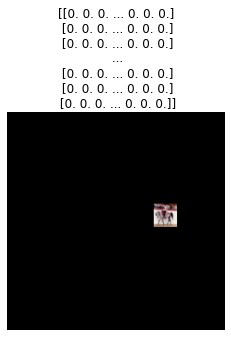

In [25]:
for image, label in ds_train_encoded.take(1):    
    show(image, label)

In [26]:
ds_train_encoded = ds_train_encoded.batch(32)
ds_train_encoded = ds_train_encoded.prefetch(tf.data.experimental.AUTOTUNE)

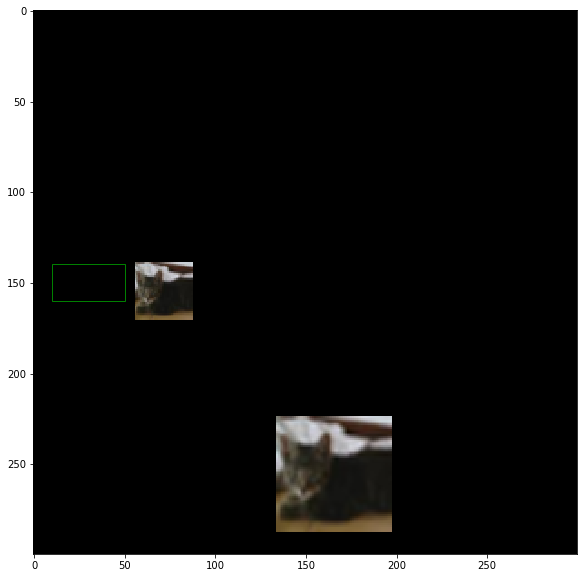

In [ ]:
import matplotlib.patches as patches

i = 9
n = 8605

fig,ax = plt.subplots(1, figsize=(10,10))
ax.imshow(x_train_od[i])

box = y_train_encoded[i,n,-4:]
rect = patches.Rectangle((box[1],box[0]),box[3] - box[1], box[2] - box[0],linewidth=1,edgecolor='g',facecolor='none')
#rect = patches.Rectangle((box[0] - box[2]/2, box[1] - box[3]/2),box[2], box[3],linewidth=1,edgecolor='g',facecolor='none')
ax.add_patch(rect)

plt.show()

In [27]:
def MobileNetSSD(input_shape,
                classes,
                alpha=1.0):
        
    inputs = layers.Input(shape=input_shape)
    
    #300x300
    x = layers.Conv2D(64, kernel_size=3, padding='same', use_bias=False, activation='relu')(inputs)
    x = layers.Conv2D(64, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    #150x150
    x = layers.Conv2D(128, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(128, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    #75x75
    x = layers.Conv2D(256, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)
    x = layers.MaxPool2D(pool_size=(2,2), strides=(2,2), padding='same')(x)

    #38x38
    x = layers.Conv2D(512, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=3, padding='same', use_bias=False, activation='relu')(x)    
    
    classifier_1 = layers.Conv2D(4 * (classes + 4), kernel_size = 3, padding='same', use_bias=False, name='classifier_1')(x)

    #19x19    
    x = layers.Conv2D(1024, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(1024, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    
    classifier_2 = layers.Conv2D(6 * (classes + 4), kernel_size = 3, padding='same', use_bias=False, name='classifier_2')(x)
        
    x = layers.Conv2D(256, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(512, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) #10x10
    
    classifier_3 = layers.Conv2D(6 * (classes + 4), kernel_size = 3, padding='same', use_bias=False, name='classifier_3')(x)
    
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 5x5
    
    classifier_4 = layers.Conv2D(6 * (classes + 4), kernel_size = 3, padding='same', use_bias=False, name='classifier_4')(x)
    
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same', use_bias=False, activation='relu')(x) # 3x3
    
    classifier_5 = layers.Conv2D(4 * (classes + 4), kernel_size = 3, padding='same', use_bias=False, name='classifier_5')(x)
    
    x = layers.Conv2D(128, kernel_size=1, padding='same', use_bias=False, activation='relu')(x)
    #x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)))(x)
    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='valid', use_bias=False, activation='relu')(x) # 1x1
    
    classifier_6 = layers.Conv2D(4 * (classes + 4), kernel_size = 3, padding='same', use_bias=False, name='classifier_6')(x)
    
    #Flatten classifiers? and concatenate?
    #classifier_1 = layers.Flatten()(classifier_1)
    #classifier_2 = layers.Flatten()(classifier_2)
    #classifier_3 = layers.Flatten()(classifier_3)
    #classifier_4 = layers.Flatten()(classifier_4)
    #classifier_5 = layers.Flatten()(classifier_5)
    #classifier_6 = layers.Flatten()(classifier_6)
    #detections = layers.concatenate([classifier_1, classifier_2, classifier_3, classifier_4, classifier_5, classifier_6])
    
    B = 1 #classifier_1.shape[0]
    
    classifier_1 = layers.Reshape((layer_width[0]*layer_width[0]*num_boxes[0], classes+4))(classifier_1)
    classifier_2 = layers.Reshape((layer_width[1]*layer_width[1]*num_boxes[1], classes+4))(classifier_2)
    classifier_3 = layers.Reshape((layer_width[2]*layer_width[2]*num_boxes[2], classes+4))(classifier_3)
    classifier_4 = layers.Reshape((layer_width[3]*layer_width[3]*num_boxes[3], classes+4))(classifier_4)
    classifier_5 = layers.Reshape((layer_width[4]*layer_width[4]*num_boxes[4], classes+4))(classifier_5)
    classifier_6 = layers.Reshape((layer_width[5]*layer_width[5]*num_boxes[5], classes+4))(classifier_6)
    
    detections = layers.concatenate([classifier_1, classifier_2, classifier_3, classifier_4, classifier_5, classifier_6], axis=-2)

    outputs = detections

    
    return Model(inputs=inputs, outputs=outputs)


In [28]:
model = MobileNetSSD((IMG_SIZE, IMG_SIZE,3), classes=n_classes+1, alpha=1.0)

In [29]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 300, 300, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 300, 300, 64) 36864       conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 150, 150, 64) 0           conv2d_1[0][0]                   
______________________________________________________________________________________________

## Model compile and Training
이제 위에서 작성한 코드를 이용하여 모델을 생성하고 컴파일하자. 지금까지 배운 Tensorflow API들을 활용하면 쉽게 처리할 수 있다.

In [30]:
log_dir = './'
model_name = 'mobilenetv2'
model_csv_path  = os.path.join(log_dir, (model_name + '.csv'))

In [31]:
class SSDLoss():
    def __init__(self, neg_pos_ratio=3, n_neg_min=0, alpha=1.0, background_id=10):
        self.neg_pos_ratio = neg_pos_ratio
        self.n_neg_min = 0
        self.alpha = alpha
        self.background_id = background_id
        
    def smoothL1Loss(self, y_true, y_pred):
        """
        y_true: ground truth localization tensor, shape: (batch_size, num_boxes, 4)
        y_pred: predicted localization tensor, shape: (batch_size, num_boxes, 4)
        """
        diff = tf.abs(y_pred - y_true)
        l1_loss = tf.where(tf.less(diff, 1), 0.5 * diff ** 2, diff - 0.5)

        return tf.reduce_sum(l1_loss, axis=-1)
        
    def compute_loss(self, y_true, y_pred):    
        """
        y_true: (batch_size, # boxes, n_classes + 4)
        y_pred: (batch_size, # boxes, n_classes + 4)
        """
        #Get the size of tensor
        batch_size = tf.shape(y_true)[0]
        n_boxes = tf.shape(y_pred)[1]
                
        #classification loss
        class_pred = y_pred[:,:,:n_classes]
        class_true = tf.maximum(y_true[:,:,:n_classes], 1e-15)

        class_loss = -tf.reduce_sum(class_true * tf.math.log(class_pred), axis = -1)
        class_loss = tf.cast(class_loss, dtype=tf.float32) # (batch_size, n_boxes)

        negatives = y_true[:,:,self.background_id] # Class is background, (batch_size, n_boxes)
        positives = tf.cast(tf.reduce_max(y_true[:,:,:n_classes-1], axis=-1), dtype=tf.float32) # Class is NOT background, (batch_size, n_boxes)       

        n_positives = tf.cast(tf.reduce_sum(positives), dtype=tf.float32) # number of positive boxes, single number
        
        # Loss for positive boxes
        pos_class_loss = tf.reduce_sum(class_loss * positives, axis=-1) # (batch_size)  
        print('pos_class_loss: ', pos_class_loss)
        
        #localization loss
        loc_pred = y_pred[:,:,n_classes:]
        loc_true = y_true[:,:,n_classes:]
        loc_loss = tf.cast(self.smoothL1Loss(y_true, y_pred), dtype=tf.float32) # (batch_size, n_boxes)        
        
        
        
        # Include only positive boxes in calculating localization loss
        loc_loss = tf.reduce_sum(positives * loc_loss, axis=-1) #(batch_size)        
        print('loc loss: ', loc_loss)
        return loc_loss
        
        # Loss for negative boxes
        neg_class_loss_all = class_loss * negatives #(batch_size, n_boxes)
        n_neg_losses = tf.math.count_nonzero(neg_class_loss_all, dtype=tf.int32) # The number of nonzero entries in neg_class_loss_all
        
        # Keep the number of negative boxes between n_neg_min and neg_pos_ratio * positive_boxes        
        n_negative_keep = tf.minimum(tf.maximum(self.neg_pos_ratio * tf.cast(n_positives, dtype=tf.int32), self.n_neg_min), n_neg_losses)
        
        def f1():
            return tf.zeros([batch_size])
        
        def f2():
            #Resahpe neg_class_loss_all to 1d array
            neg_class_loss_all_1D = tf.reshape(neg_class_loss_all, [-1])

            # Find top 'n_negative_keep' boxes from neg_class_loss_all_1D
            values, indices = tf.nn.top_k(neg_class_loss_all_1D, k=n_negative_keep, sorted=False)

            #Then create a mask for negative boxes: For selected box above, set them as 0
            negatives_keep = tf.scatter_nd(indices=tf.expand_dims(indices, axis=1),
                                           updates=tf.ones_like(indices, dtype=tf.int32),
                                           shape=tf.shape(neg_class_loss_all_1D))
            negatives_keep = tf.cast(tf.reshape(negatives_keep, [batch_size, n_boxes]), dtype=tf.float32)            

            #Finally compute negative loss
            neg_class_loss = tf.reduce_sum(class_loss * negatives_keep, axis=-1) #(batch_size)
            
            return neg_class_loss
        
        neg_class_loss = tf.cond(tf.equal(n_neg_losses, tf.constant(0)), f1, f2)   
        
        
        class_loss = pos_class_loss  + neg_class_loss
        
        #Combine localization and classification loss, divide by matched default box(n_positives)
        total_loss = (class_loss + loc_loss * self.alpha) / tf.maximum(1.0, n_positives)
        
        # We divided by n_positives - # of all matched default boxes of "a batch"
        # Since keras divides by the size of batch, it is double division
        # To adjust this, we multiply by batch_size
        total_loss = total_loss * tf.cast(batch_size, dtype=tf.float32)
        print("total loss:", total_loss)
        
        return total_loss

CallBack 함수를 지정하면 필요한 대로 트레이닝 옵션들을 추가할 수 있다.

In [32]:
#decay could be applied using Learning rate scheduler
def decay(epoch):
    return 0.045 * (0.98 **(epoch-1))

In [33]:
callbacks = []
"""
#TensorBoard로 훈련 성과를 보고 싶은 경우
callbacks.append(TensorBoard(log_dir=log_dir, histogram_freq=1))
"""
"""
#Checkpoint설정
checkpoint_dir = './training_checkpoints'
model_cp_path = os.path.join(checkpoint_dir, "ckpt_{epoch}")
callbacks.append(ModelCheckpoint(model_cp_path, monitor='val_loss', save_best_only=True))
"""
"""
#Learning rate 스케쥴 설정
callbacks.append(LearningRateScheduler(decay))
"""
#General logs on csv
callbacks.append(CSVLogger(model_csv_path)) 

모델을 컴파일 하고 트레이닝을 시작하자.<br>
* Optimizer: RMSprop을 사용하고 최초 Learning rate=0.045, 매 Epoch마다 0.98씩 decay 되도록 설정해주자.
* Loss: Categorical cross entropy를 사용하자.

In [34]:
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1, background_id=10)
model.compile(loss=ssd_loss.compute_loss,     
              optimizer=tf.keras.optimizers.SGD(lr=0.001, momentum=0.9, decay=0))


In [35]:
history = model.fit(ds_train_encoded,
              #datagen.flow(train_images, train_labels, batch_size=batch_size),
              #steps_per_epoch=math.ceil(len(train_images) / batch_size),
              epochs=100,
              verbose=1)
              #callbacks=callbacks)
              #validation_data=(val_images, val_labels))

Epoch 1/100
pos_class_loss:  Tensor("compute_loss/Sum_2:0", shape=(None,), dtype=float32)
loc loss:  Tensor("compute_loss/Sum_4:0", shape=(None,), dtype=float32)
pos_class_loss:  Tensor("compute_loss/Sum_2:0", shape=(None,), dtype=float32)
loc loss:  Tensor("compute_loss/Sum_4:0", shape=(None,), dtype=float32)
   2/1563 [..............................] - ETA: 47:31:36 - loss: 0.6040

KeyboardInterrupt: ignored

In [ ]:
history = model.fit(x_train_od[:32], y_train_encoded[:32,:,:-4],
              #datagen.flow(train_images, train_labels, batch_size=batch_size),
              #steps_per_epoch=math.ceil(len(train_images) / batch_size),
              epochs=100,
              verbose=1)
              #callbacks=callbacks)
              #validation_data=(val_images, val_labels))

NameError: name 'x_train_od' is not defined

In [ ]:
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)
print('Model Name: ', model_name)
print('Test loss     : {:.5f}'.format(test_loss))
print('Test accuracy : {:.5f}'.format(test_acc))

# 과제: MobileNet 변형해 보기

